## Instance Based Learning

The main instance-based classifier defined in `scikit-learn` is `KNeighborsClassifier`, which uses a default of $k=5$.  

Below, we work through a few examples using it. We also work through an example using `KNeighborsRegressor`.

* http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

We'll use the Wisconsin breast cancer data set. Recall that it has the following attributes:

1. ID number
2. Diagnosis (M = malignant, B = benign)
3. -32.: Mean, standard deviation, and "worst" of the below for each cell nucleus:

  * radius (mean of distances from center to points on the perimeter)
  * texture (standard deviation of gray-scale values)
  * perimeter
  * area
  * smoothness (local variation in radius lengths)
  * compactness (perimeter^2 / area - 1.0)
  * concavity (severity of concave portions of the contour)
  * concave points (number of concave portions of the contour)
  * symmetry 
  * fractal dimension ("coastline approximation" - 1)

We've modified the target to be 0 (M) and 1 (B).

### Brute force, kd trees, ball trees

It is possible to modify the underlying algorithm used by `KNeighborsClassifier`. The default, `algorithm=auto`, will attempt to choose an appropriate scheme based on the data. The other alternatives are `brute`, which will use a brute force approach (comparing each pair), and `kd_tree` and `ball_tree`. The latter two will use those data structures to delineates regions in the search space. `auto` will attempt to choose an appropriate scheme from the three. 

#### kd trees

In a *kd-tree*, the space is iteratively split by a plane perpendicular to a chosen axis. In Witten *et al.*, axes are chosen in descending order of variance. After an axis is chosen, the median instance is used as the split point. The splits naturally define a binary tree (which specifies how the k-dimensional space is divided into hyperrectangles). The use of kd-trees can be much faster than bruth-force knn but can also become inefficient at high dimensionalities. 

![](kd-tree1.png)

The above tree has two splits, the first at (7,4) and the second at (6,7). In the tree, each instance of the training set is a single node. 

To classify a new instance, we traverse the tree from the root, locating the region containing the instance. Below is another example. In it, the leaf node (noted in black)  in the region containing the new instance might not be the new instance's closest neighbor. However, it can be used to define a radius. To find closer neighbors, we traverse up the tree to identify the sibling region. We check there for a closer instance (check to see if it intersects the circle). If none is found, we move up to the parent and check its sibling. If it intersects, then we check its descendents.  

![](kd-tree2.png)

It is often the case that determining the nearest neighbor takes logarithmic time relative to the number of instances in the training set. 

#### ball trees

Ball trees, which use hyperspheres rather than hyperrectangles, supposedly perform better. Witten *et al* recommend that they should be used when the number of dimensions is large (they do not quantify "large", however). 

**Note:** The images are from Chapter 4 of Witten et al. 

## Classifiers

Below, we create 3 classifiers, one using each of the algorithms available to `KNeighborsClassifier`. Note that we scale the data using a ``MinMaxScaler``. Afterwards we generate confusion matrices for each. 

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np;
import pandas as pd
import sklearn.metrics as metrics

In [11]:
# Read in a data set using Pandas. 
wdbc_data = '../data-sets/wdbc.csv'
df = pd.read_csv(wdbc_data, header=0)
df.head()

,id,radiusAvg,textureAvg,perimeterAvg,areaAvg,smoothnessAvg,compactnessAvg,concavityAvg,concavepointsAvg,symmetryAvg,...,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavepointsWorst,symmetryWorst,fractaldimWorst,c
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.preprocessing import MinMaxScaler

data = df.iloc[:].values

test_percent = 0.3

# extract X and y values from the data set; 
X = data[:, 1:-1]
y = data[:, -1]

# use a min max scaler to put the features in [0,1]
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)            


X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=test_percent, shuffle=True)

knn1 = KNeighborsClassifier(n_neighbors=2, algorithm='brute' )
knn1.fit(X_train, y_train) 

knn2 = KNeighborsClassifier(n_neighbors=5, algorithm='kd_tree')
knn2.fit(X_train, y_train) 

knn3 = KNeighborsClassifier(n_neighbors=10, algorithm='ball_tree')
knn3.fit(X_train, y_train) 


predictedKnn1 = np.array(knn1.predict(X_test))
predictedKnn2 = np.array(knn2.predict(X_test))
predictedKnn3 = np.array(knn3.predict(X_test))

print("Training set size:", len(y_train))
print("Testing set size:", len(y_test))

Training set size: 398
Testing set size: 171


In this dataset, `B` is 1 and `M` is 0. 

In [13]:
for predarray in [predictedKnn1, predictedKnn2, predictedKnn3]:
    cm = metrics.confusion_matrix(y_test, predarray,labels=[1,0])
    print("","B","M",sep="\t")
    print("B",cm[0,0],cm[0,1],sep="\t" )
    print("M",cm[1,0],cm[1,1],sep="\t" )
    print('-'*20)
    
print("accuracy (brute):", metrics.accuracy_score(predictedKnn1,y_test))
print("accuracy (kd-tree):",metrics.accuracy_score(predictedKnn2,y_test))
print("accuracy (ball):",metrics.accuracy_score(predictedKnn3,y_test))

	B	M
B	104	8
M	4	55
--------------------
	B	M
B	110	2
M	3	56
--------------------
	B	M
B	109	3
M	4	55
--------------------
accuracy (brute): 0.9298245614035088
accuracy (kd-tree): 0.9707602339181286
accuracy (ball): 0.9590643274853801


Below, we experiment with various values for $k$.

k=1:	0.953
k=2:	0.948
k=3:	0.969
k=4:	0.962
k=5:	0.966
k=6:	0.967
k=7:	0.969
k=8:	0.970
k=9:	0.969
k=10:	0.970
k=11:	0.969
k=12:	0.968
k=13:	0.971
k=14:	0.970
k=15:	0.970
k=16:	0.970
k=17:	0.966
k=18:	0.969
k=19:	0.964
k=20:	0.965
k=21:	0.963
k=22:	0.963
k=23:	0.962
k=24:	0.963
k=25:	0.959
k=26:	0.959
k=27:	0.959
k=28:	0.960
k=29:	0.958


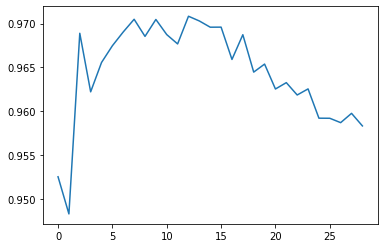

In [14]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
first = []
for i in range(1,30):    
    knnX = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    cvk = RepeatedKFold(n_splits=10, n_repeats=10)
    scores = cross_val_score(knnX, X, y, cv=cvk)
    first.append(np.average(scores))
    print("k={}:\t{:.3f}".format(i,np.average(scores)))
    
plt.plot(first)

### Seeing the neighbors

It is possible to return the nearest neighbors of a test point (or group of points).

In [15]:
neighbors = knn1.kneighbors(X_test, 3,False)
print("number of instances:", len(neighbors))
print(neighbors)

number of instances: 171
[[263 126 330]
 [ 33 389 321]
 [393 260 291]
 [229 198 311]
 [  1  91 164]
 [346  33  99]
 [139 322 117]
 [216 274 129]
 [249  74   6]
 [ 74 162 350]
 [260 333  95]
 [393 278  87]
 [123 318 377]
 [339  61 215]
 [231 171 384]
 [171 129 206]
 [321  32  15]
 [ 17 362 395]
 [286 381  19]
 [295 315 146]
 [271  57 265]
 [252 364 365]
 [385  74 366]
 [256 147  30]
 [131 240 321]
 [340 129 182]
 [207 240 243]
 [180 289 109]
 [ 95 260 333]
 [101 337 256]
 [136 264 193]
 [255 309 336]
 [334 311 191]
 [285 292  62]
 [230 159 304]
 [351 395 362]
 [256 121  30]
 [240 131 315]
 [171 362 165]
 [317 201 302]
 [291   5 255]
 [305 183  67]
 [ 57 109 275]
 [ 10  67 343]
 [363 253  29]
 [339 143  61]
 [261 136 138]
 [307 191 340]
 [ 40 152 112]
 [376 358 390]
 [365 265 271]
 [265 159 196]
 [ 14  93 294]
 [230 304 169]
 [237 319  12]
 [365 271 109]
 [264 365 261]
 [361 383 122]
 [260 113  16]
 [385  65 316]
 [383  58 357]
 [ 19  30 170]
 [162 181  44]
 [197 327 157]
 [ 24 286 199]


## `RadiusNeighborsClassifier`

An alternative classifier, `RadiusNeighborsClassifier`, uses a radius to pick neighbors to be used in a majority vote. 

In [16]:
from sklearn.neighbors import RadiusNeighborsClassifier

r1 = RadiusNeighborsClassifier(radius =1.45)
r1.fit(X_train, y_train) 

r2 = RadiusNeighborsClassifier(radius = 3)
r2.fit(X_train, y_train) 


predictedR1 = np.array(r1.predict(X_test))
predictedR2 = np.array(r2.predict(X_test))

for predarray in [predictedR1, predictedR2]:
    cm = metrics.confusion_matrix(y_test, predarray,labels=[1,0])
    print("","B","M",sep="\t")
    print("B",cm[0,0],cm[0,1],sep="\t" )
    print("M",cm[1,0],cm[1,1],sep="\t" )
    print('-'*20)
    
print("accuracy (radius 1):",metrics.accuracy_score(predictedR1,y_test))
print("accuracy (radius 2):",metrics.accuracy_score(predictedR2,y_test))

	B	M
B	111	1
M	46	13
--------------------
	B	M
B	112	0
M	59	0
--------------------
accuracy (radius 1): 0.7251461988304093
accuracy (radius 2): 0.6549707602339181


## Regression

`KNeighborsRegressor` can be used in regression problems. Below, we use the builtin Boston housing prices data set. We wonly use a select number of its input attributes. 

In [12]:
from sklearn.datasets import load_boston
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
boston = load_boston()
X = boston.data[:,[0,1,2,4,5,6,7,10,11,12]] 
y = boston.target
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

We scale the data using a min-max scaler, which will put the attribute values in [0,1]. We then construct two models, one using the unscaled data, and the other using the scaled data. Here, it appears to make a significant difference. 

Below, we generate a collection of 20 paried scores (for increasing values of $k$), each the result of repeated cross-validation.

In [15]:
Xscaled = min_max_scaler.fit_transform(X)   

first = []
sec = []
for i in range(1,21):
    reg = KNeighborsRegressor(n_neighbors=i)
    cvk = RepeatedKFold(n_splits=10, n_repeats=10, random_state=i)
    scores = cross_val_score(reg, X, y, cv=cvk)
    scores2 = cross_val_score(reg, Xscaled, y, cv=cvk)
    first.append(np.average(scores))
    sec.append(np.average(scores2))
    print("k={}:\t{:.2f}\t{:.2f}".format(i,np.average(scores),np.average(scores2)))


k=1:	0.42	0.77
k=2:	0.53	0.81
k=3:	0.55	0.83
k=4:	0.59	0.84
k=5:	0.58	0.82
k=6:	0.56	0.80
k=7:	0.55	0.79
k=8:	0.54	0.78
k=9:	0.53	0.76
k=10:	0.52	0.74
k=11:	0.51	0.74
k=12:	0.49	0.72
k=13:	0.49	0.71
k=14:	0.48	0.70
k=15:	0.49	0.70
k=16:	0.48	0.69
k=17:	0.48	0.69
k=18:	0.48	0.69
k=19:	0.47	0.68
k=20:	0.46	0.68


Below, we plot the results of each type of classifier. 

Text(0, 0.5, 'Accuracy')

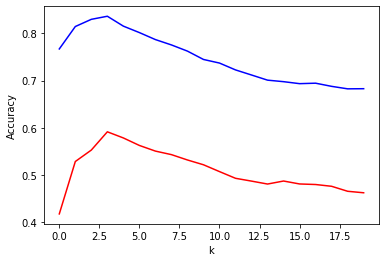

In [16]:
import matplotlib
import matplotlib.pyplot as plt
result = plt.plot(range(len(first)), first, "r",range(len(sec)), sec,"b")
plt.xlabel('k')
plt.ylabel('Accuracy')


## Comparison to decision tree

In [17]:
from sklearn import tree
clf = tree.DecisionTreeRegressor()
scores = cross_val_score(clf, X, y, cv=cvk)
print("mean", np.average(scores))
scores2 = cross_val_score(clf, Xscaled, y, cv=cvk)
print("mean", np.average(scores2))

mean 0.7278036782255048
mean 0.7174653448806988
